# Node2Vec using the cora dataset

In [1]:
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score

import os
import networkx as nx
import numpy as np
import pandas as pd
from tensorflow import keras

from stellargraph import StellarGraph
from stellargraph.data import BiasedRandomWalk
from stellargraph.data import UnsupervisedSampler
from stellargraph.data import BiasedRandomWalk
from stellargraph.mapper import Node2VecLinkGenerator, Node2VecNodeGenerator
from stellargraph.layer import Node2Vec, link_classification

from stellargraph import datasets
from IPython.display import display, HTML

%matplotlib inline

2022-05-22 22:01:19.361771: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Dataset
Load in cora dataset

In [38]:
def get_cora_data() -> (StellarGraph, pd.Series):

    dataset = datasets.Cora()
    display(HTML(dataset.description))
    G, subjects = dataset.load(largest_connected_component_only=True)

    return G, subjects

In [3]:
G, subjects = get_cora_data()
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2485, Edges: 5209

 Node types:
  paper: [2485]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5209]
        Weights: all 1 (default)
        Features: none


## Node2Vec Algorithm

In [18]:
def run_node2vec(graph: StellarGraph, p: float, q: float, walk_number: int = 100, walk_length: int = 5, batch_size: int = 50, epochs: int = 2, emb_size: int = 128):

    # create walker
    walker = BiasedRandomWalk(
        graph,
        n=walk_number,
        length=walk_length,
        p=p,  # defines probability, 1/p, of returning to source node
        q=q,  # defines probability, 1/q, for moving to a node away from the source node
    )

    # samples walks in a graph
    unsupervised_samples = UnsupervisedSampler(graph, nodes=list(graph.nodes()), walker=walker)

    # generates data for context link prediction
    generator = Node2VecLinkGenerator(graph, batch_size)

    # implementation of the node2vec algorithm
    node2vec = Node2Vec(emb_size, generator=generator)

    # get input/output to hook up to keras model
    x_inp, x_out = node2vec.in_out_tensors()

    #
    prediction = link_classification(
        output_dim=1, output_act="sigmoid", edge_embedding_method="dot"
    )(x_out)

    # composes the keras mmodel
    model = keras.Model(inputs=x_inp, outputs=prediction)
    model.compile(
        optimizer=keras.optimizers.Adam(lr=1e-3),
        loss=keras.losses.binary_crossentropy,
        metrics=[keras.metrics.binary_accuracy],
    )

    # fit the model
    history = model.fit(
        generator.flow(unsupervised_samples),
        epochs=epochs,
        verbose=1,
        use_multiprocessing=False,
        workers=4,
        shuffle=True,
    )

    # generates the node embeddings
    x_inp_src = x_inp[0]
    x_out_src = x_out[0]
    embedding_model = keras.Model(inputs=x_inp_src, outputs=x_out_src)
    node_gen = Node2VecNodeGenerator(G, batch_size).flow(subjects.index)
    node_embeddings = embedding_model.predict(node_gen, workers=4, verbose=1)

    return node_embeddings

In [50]:
embeddings = run_node2vec(G, p=0.5, q=2.0, emb_size=32)

link_classification: using 'dot' method to combine node embeddings into edge embeddings


/Users/jamescauwelier/Library/Caches/pypoetry/virtualenvs/graph-classification-experiments-RDFHJCIl-py3.8/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/2
39760/39760 [==============================] - 75s 2ms/step - loss: 0.4357 - binary_accuracy: 0.7690
Epoch 2/2
50/50 [==============================] - 0s 3ms/step


## Optional visualisation

/Users/jamescauwelier/Library/Caches/pypoetry/virtualenvs/graph-classification-experiments-RDFHJCIl-py3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/jamescauwelier/Library/Caches/pypoetry/virtualenvs/graph-classification-experiments-RDFHJCIl-py3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


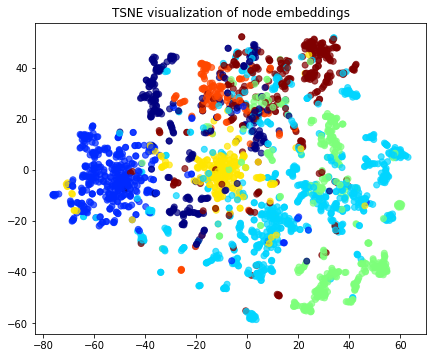

In [51]:
transform = TSNE  # PCA

trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(embeddings)

# draw the embedding points, coloring them by the target label (paper subject)
alpha = 0.7
label_map = {l: i for i, l in enumerate(np.unique(subjects))}
node_colours = [label_map[target] for target in subjects]

plt.figure(figsize=(7, 7))
plt.axes().set(aspect="equal")
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=node_colours,
    cmap="jet",
    alpha=alpha,
)
plt.title("{} visualization of node embeddings".format(transform.__name__))
plt.show()

## Node classification

In [24]:
from typing import Any
from sklearn.metrics import f1_score, multilabel_confusion_matrix


def run_classifier(X, y) -> (float, float, float, Any):

    # splits data into test vs train
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.1, test_size=None)
    print(
        "Array shapes:\n X_train = {}\n y_train = {}\n X_test = {}\n y_test = {}".format(
            X_train.shape, y_train.shape, X_test.shape, y_test.shape
        )
    )

    # classifier training
    clf = LogisticRegressionCV(
        Cs=10, cv=10, scoring="accuracy", verbose=False, multi_class="ovr", max_iter=300
    )
    clf.fit(X_train, y_train)

    # predict hold-out test set
    y_pred = clf.predict(X_test)

    # calculate performance
    accuracy = accuracy_score(y_test, y_pred)
    f1_micro = f1_score(y_test, y_pred, average="micro")
    f1_macro = f1_score(y_test, y_pred, average="macro")
    confusion = multilabel_confusion_matrix(y_test, y_pred)

    return accuracy, f1_micro, f1_macro, confusion

In [25]:
accuracy, f1_micro, f1_macro, confusion = run_classifier(X=embeddings, y=np.array(subjects))

Array shapes:
 X_train = (248, 128)
 y_train = (248,)
 X_test = (2237, 128)
 y_test = (2237,)


In [26]:
accuracy

0.7402771569065713

In [27]:
f1_micro

0.7402771569065713

In [28]:
f1_macro

0.7150629433908363

In [31]:
np.array(confusion)

array([[[1930,   43],
        [ 107,  157]],

       [[1819,   58],
        [  33,  327]],

       [[1388,  187],
        [ 120,  542]],

       [[1816,   85],
        [ 100,  236]],

       [[2016,   27],
        [  66,  128]],

       [[2089,   29],
        [  55,   64]],

       [[1783,  152],
        [ 100,  202]]])

## Experimenting with input values

### Defining experiment function

In [57]:
from IPython.core.display_functions import clear_output, display


def experiment(experiment_graph: StellarGraph, experiment_subjects, walk_number_values=None, walk_length_values=None, q_values=None,
               p_values=None, embedding_size=128, classification_repeats=100, split=1, experiment_repeats=1) -> pd.DataFrame:

    # default values
    if p_values is None:
        p_values = [1.0]
    if q_values is None:
        q_values = [1.0]
    if walk_length_values is None:
        walk_length_values = [3]
    if walk_number_values is None:
        walk_number_values = [20]

    # iterate through our variables
    results = None
    for walk_number in walk_number_values:
        for walk_length in walk_length_values:
            for q in q_values:
                for p in p_values:

                    accuracies = np.array([])
                    micros = np.array([])
                    macros = np.array([])

                    for r in np.arange(0, experiment_repeats):

                        # run experiment
                        embeddings = run_node2vec(experiment_graph, p=p, q=q, walk_number=walk_number, walk_length=walk_length)
                        accuracy, f1_micro, f1_macro, _ = run_classifier(X=embeddings, y=np.array(experiment_subjects))

                        accuracies = np.append(accuracies, [accuracy])
                        micros = np.append(micros, [f1_micro])
                        macros = np.append(macros, [f1_macro])

                    mean_accuracy = np.mean(accuracies)
                    mean_f1_micro = np.mean(micros)
                    mean_f1_macro = np.mean(macros)

                    # collect metrics
                    metrics_data_row = np.array([[walk_number, walk_length, p, q, mean_accuracy, mean_f1_micro, mean_f1_macro]])
                    if results is None:
                        results = metrics_data_row
                    else:
                        results = np.append(results, metrics_data_row, axis=0)

                    results_table = pd.DataFrame(data=results, columns=['walk number', 'walk length', 'p', 'q', 'accuracy', 'f1_micro', 'f1_macro'])

                    clear_output(wait=True)
                    display(results_table)

    return results_table

### Running experiments

Notes that more experiments were run than what is visible here by adjusting parameters. See the report file for those details

In [61]:
# experiment parameters
walk_length_values = [6]
walk_number_values = [20, 40, 60, 80, 100, 120]
q_values = np.array([1.0])
p_values = np.array([1.0])

# run the experiments
graph, subjects = get_cora_data()
experiment_results = experiment(graph, subjects, p_values=p_values, q_values=q_values, walk_length_values=walk_length_values, walk_number_values=walk_number_values, experiment_repeats=3)

,walk number,walk length,p,q,accuracy,f1_micro,f1_macro
0,20.0,6.0,1.0,1.0,0.529876,0.529876,0.468841
1,40.0,6.0,1.0,1.0,0.707942,0.707942,0.679973
2,60.0,6.0,1.0,1.0,0.745492,0.745492,0.725976
3,80.0,6.0,1.0,1.0,0.741618,0.741618,0.714193
4,100.0,6.0,1.0,1.0,0.766950,0.766950,0.746561
5,120.0,6.0,1.0,1.0,0.762629,0.762629,0.736514


In [62]:
postfix = '-walk-number'
experiment_results.to_excel('./cora-experiments{}.xlsx'.format(postfix))
experiment_results.to_pickle('./cora-experiments{}.pkl'.format(postfix))
experiment_results.to_csv('./cora-experiments{}.csv'.format(postfix))

In [71]:
# experiment parameters
walk_length_values = [9]
walk_number_values = [60]
p_values = np.array([1.0])
q_values = np.array([0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0])

# run the experiments
graph, subjects = get_cora_data()
experiment_results = experiment(graph, subjects, p_values=p_values, q_values=q_values, walk_length_values=walk_length_values, walk_number_values=walk_number_values, experiment_repeats=3)

,walk number,walk length,p,q,accuracy,f1_micro,f1_macro
0,60.0,9.0,1.0,0.01,0.749516,0.749516,0.723009
1,60.0,9.0,1.0,0.10,0.741916,0.741916,0.695959
2,60.0,9.0,1.0,0.50,0.762032,0.762032,0.742093
3,60.0,9.0,1.0,1.00,0.754731,0.754731,0.734202
4,60.0,9.0,1.0,5.00,0.727313,0.727313,0.705508
5,60.0,9.0,1.0,10.00,0.679928,0.679928,0.625904
6,60.0,9.0,1.0,50.00,0.669498,0.669498,0.648523


In [72]:
postfix = '-qvals-l9-n60'
experiment_results.to_excel('./cora-experiments{}.xlsx'.format(postfix))
experiment_results.to_pickle('./cora-experiments{}.pkl'.format(postfix))
experiment_results.to_csv('./cora-experiments{}.csv'.format(postfix))

In [70]:
latex_filename = open('./cora-experiments{}.tex'.format(postfix))
experiment_results.style.to_latex(latex_filename)

FileNotFoundError: [Errno 2] No such file or directory: './cora-experiments-qpvals-l9-n60.tex'